In [29]:
# For data manipulation
import numpy as np
import pandas as pd
import yfinance as yf
import pyfolio as pf
from hmmlearn import hmm
from sklearn.utils import check_random_state

# For data visualization
import matplotlib.pyplot as plt

# For ignoring warnings
import warnings
warnings.filterwarnings('ignore')

In [ ]:

def directional_change_events(data, theta=0.2):
    data = data.copy()
    data["Event"] = 0.0

    event = "upward"
    ph = data['Close'].iloc[0]
    pl = data['Close'].iloc[0]

    for t in range(0, len(data.index)):
    
        if event == "downward":
            if data["Close"].iloc[t] >= pl * (1 + theta):
                event = "upward"            
                ph = data["Close"].iloc[t]
            else:
    
                if data["Close"].iloc[t] < pl:
                 
                    pl = data["Close"].iloc[t]
                
                    data["Event"].iloc[t] = 1
     
        elif event == "upward":
            if data["Close"].iloc[t] <= ph * (1 - theta):  
                event = "downward"
                pl = data["Close"].iloc[t]
            else:
                if data["Close"].iloc[t] > ph: 
                    ph = data["Close"].iloc[t]
                    data["Event"].iloc[t] = -1

    data['peak_trough_prices'] = np.where(data['Event']!=0, data['Close'],0)
    data['peak_trough_prices'].replace(to_replace=0, method='ffill', inplace=True)

    data['count'] = 0
    for i in range(1,len(data.index)):
        if data['Event'].iloc[(i-1)]!=0:
            data['count'].iloc[i] = 1+data['count'].iloc[(i-1)]
        else:
            data['count'].iloc[i] = 1

    data['TMV'] = np.where(data['Event']!=0, abs(data['peak_trough_prices']-data['peak_trough_prices'].shift())/\
                          (data['peak_trough_prices'].shift()*theta),0)

    data['T'] = np.where(data['Event']!=0, data['count'],0)
    data['R'] = np.where(data['Event']!=0, np.log(data['TMV']/data['T']*theta),0)
    data['R'] = data['R'].replace(to_replace=0, method='ffill')
    data.replace([np.inf, -np.inf], np.nan, inplace=True)

    return data

: 

: 

In [ ]:

data = yf.download('^GSPC', start='2003-12-01', end='2023-10-06', auto_adjust=True)

data['returns'] = np.log(data['Close']/data['Close'].shift(1))

data.columns = data.columns.droplevel(1)

[*********************100%***********************]  1 of 1 completed


: 

: 

In [ ]:
data

Price,Close,High,Low,Open,Volume,returns
Date,,,,,,
2007-09-17,4494.649902,4549.049805,4482.850098,4518.450195,0,NaN
2007-09-18,4546.200195,4551.799805,4481.549805,4494.100098,0,0.011404
2007-09-19,4732.350098,4739.000000,4550.250000,4550.250000,0,0.040130
2007-09-20,4747.549805,4760.850098,4721.149902,4734.850098,0,0.003207
2007-09-21,4837.549805,4855.700195,4733.700195,4752.950195,0,0.018780
...,...,...,...,...,...,...
2023-09-28,19523.550781,19766.650391,19492.099609,19761.800781,352800,-0.009832
2023-09-29,19638.300781,19726.250000,19551.050781,19581.199219,243500,0.005860
2023-10-03,19528.750000,19623.199219,19479.650391,19622.400391,221700,-0.005594


: 

: 

In [ ]:

data = directional_change_events(data, theta=0.004)

data.index = pd.to_datetime(data.index)

data.dropna(inplace=True)
data

Price,Close,High,Low,Open,Volume,returns,Event,peak_trough_prices,count,TMV,T,R
Date,,,,,,,,,,,,
2007-09-19,4732.350098,4739.000000,4550.250000,4550.250000,0,0.040130,-1.0,4732.350098,2,10.236565,2,-3.888642
2007-09-20,4747.549805,4760.850098,4721.149902,4734.850098,0,0.003207,-1.0,4747.549805,3,0.802968,3,-6.839513
2007-09-21,4837.549805,4855.700195,4733.700195,4752.950195,0,0.018780,-1.0,4837.549805,4,4.739287,4,-5.351869
2007-09-24,4932.200195,4941.149902,4837.149902,4837.149902,0,0.019377,-1.0,4932.200195,5,4.891443,5,-5.543412
2007-09-25,4938.850098,4953.899902,4878.149902,4939.100098,0,0.001347,-1.0,4938.850098,6,0.337066,6,-8.400698
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-28,19523.550781,19766.650391,19492.099609,19761.800781,352800,-0.009832,1.0,19523.550781,1,1.794439,1,-4.936768
2023-09-29,19638.300781,19726.250000,19551.050781,19581.199219,243500,0.005860,0.0,19523.550781,2,0.000000,0,-4.936768
2023-10-03,19528.750000,19623.199219,19479.650391,19622.400391,221700,-0.005594,0.0,19523.550781,1,0.000000,0,-4.936768


: 

: 

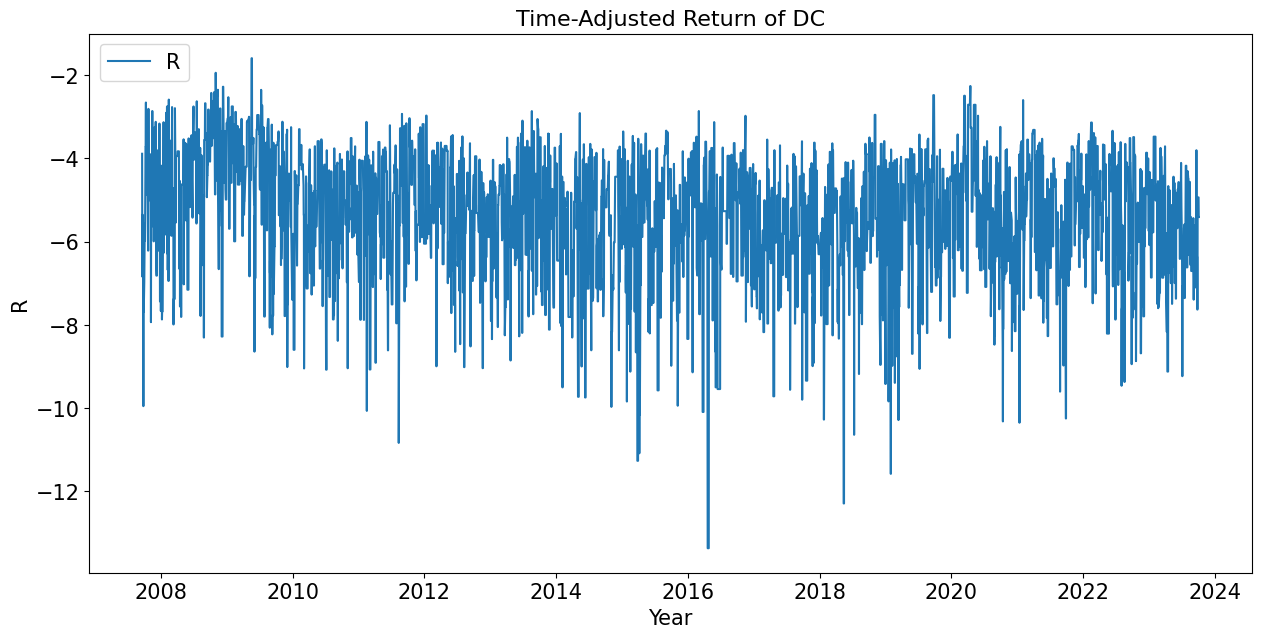

: 

: 

In [ ]:

plt.figure(figsize=(15,7))
plt.plot(data.index, data['R'], label = "R")
plt.title('Time-Adjusted Return of DC', fontsize=16)
plt.xlabel('Year', fontsize=15)
plt.ylabel('R', fontsize=15)
plt.tick_params(axis='both', labelsize=15)
plt.legend(loc=2, prop={'size': 15}, bbox_to_anchor=(0,1))

plt.show()

In [ ]:

data['Event'].value_counts()

 0.0    1909
-1.0    1200
 1.0     824
Name: Event, dtype: int64

: 

: 

In [ ]:

model = hmm.GaussianHMM(n_components = 3, covariance_type = "diag", n_iter = 100, random_state = 42)

X = data[['R']].values

results = model.fit(X)
data['states'] = results.predict(X)
data['states'].value_counts()

2    1545
0    1194
1    1194
Name: states, dtype: int64

: 

: 

In [ ]:

state0_R_vol = data['R'][data['states']==0].mean()
state1_R_vol = data['R'][data['states']==1].mean()
print(f'Volatility for state 0, 1 and 2 are {state0_R_vol:.2f} and {state1_R_vol:.2f}, respectively')

Volatility for state 0, 1 and 2 are -6.37 and -6.42, respectively


: 

: 

In [ ]:

state0_vol = data['returns'][data['states']==0].std()*np.sqrt(252)*100
state1_vol = data['returns'][data['states']==1].std()*np.sqrt(252)*100
print(f'Volatility for state 0 and 1 are {state0_vol:.2f} and {state1_vol:.2f}, respectively')

Volatility for state 0 and 1 are 13.66 and 16.61, respectively


: 

: 

In [ ]:
type(data.index)

pandas.core.indexes.datetimes.DatetimeIndex

: 

: 

In [ ]:
# Set the initial day to start the trading backtesting loop
initial_t = data.index.get_loc(data[data.index.year==2018].index[0])

# Print the initial day
initial_t

2513

: 

: 

In [ ]:

data['sma'] = data['Close'].rolling(3).mean()
data['signal'] = np.where(data['Close']>data['sma'],1.0,-1.0)
data['dc_leverage'] = 0.0
data['dc_next_state'] = 0.0

: 

: 

In [ ]:

for t in range(initial_t, (len(data.index)-1)):
    data_sample = data[['R','returns']].iloc[:(t+1)]
    dc_model = hmm.GaussianHMM(n_components = 2, covariance_type = "diag", n_iter = 200, random_state = 100)
    dc_X = data_sample[['R']].values
    dc_results = dc_model.fit(dc_X)
    data_sample['dc_states'] = dc_results.predict(dc_X)
    dc_transmat_cdf = np.cumsum(dc_results.transmat_, axis=1)
    dc_random_state = check_random_state(dc_results.random_state)
    data['dc_next_state'].iloc[t] = (dc_transmat_cdf[data_sample['dc_states'].iloc[-1]] > dc_random_state.rand()).argmax()
    
    dc_state0_vol = data_sample['R'][data_sample['dc_states']==0].mean()
    dc_state1_vol = data_sample['R'][data_sample['dc_states']==1].mean()


    if (data['dc_next_state'].iloc[t]==0) and (dc_state0_vol>dc_state1_vol):
        data['dc_leverage'].iloc[t] = 1.0

    elif (data['dc_next_state'].iloc[t]==0) and (dc_state0_vol<dc_state1_vol):
        data['dc_leverage'].iloc[t] = 2.0

    elif (data['dc_next_state'].iloc[t]==1) and (dc_state0_vol>dc_state1_vol):
        data['dc_leverage'].iloc[t] = 2.0

    else:
        data['dc_leverage'].iloc[t] = 1.0

data['signal'].iloc[-1] = 0.0

: 

: 

In [ ]:

plot_data = data.loc['2018':]
plot_data['dc_leverage'].value_counts()

2.0    958
1.0    461
0.0      1
Name: dc_leverage, dtype: int64

: 

: 

In [ ]:

plot_data['buy_hold_cum_rets'] = np.exp(plot_data['returns'].cumsum())
plot_data['basic_stra_rets'] = plot_data['returns']*plot_data['signal'].shift(1)
plot_data['basic_stra_cum_rets'] = np.exp(plot_data['basic_stra_rets'].cumsum())
plot_data['hmm_dc_stra_rets'] = plot_data['returns']*plot_data['signal'].shift(1)*plot_data['dc_leverage'].shift(1)

plot_data['hmm_dc_stra_cum_rets'] = np.exp(plot_data['hmm_dc_stra_rets'].cumsum())

: 

: 

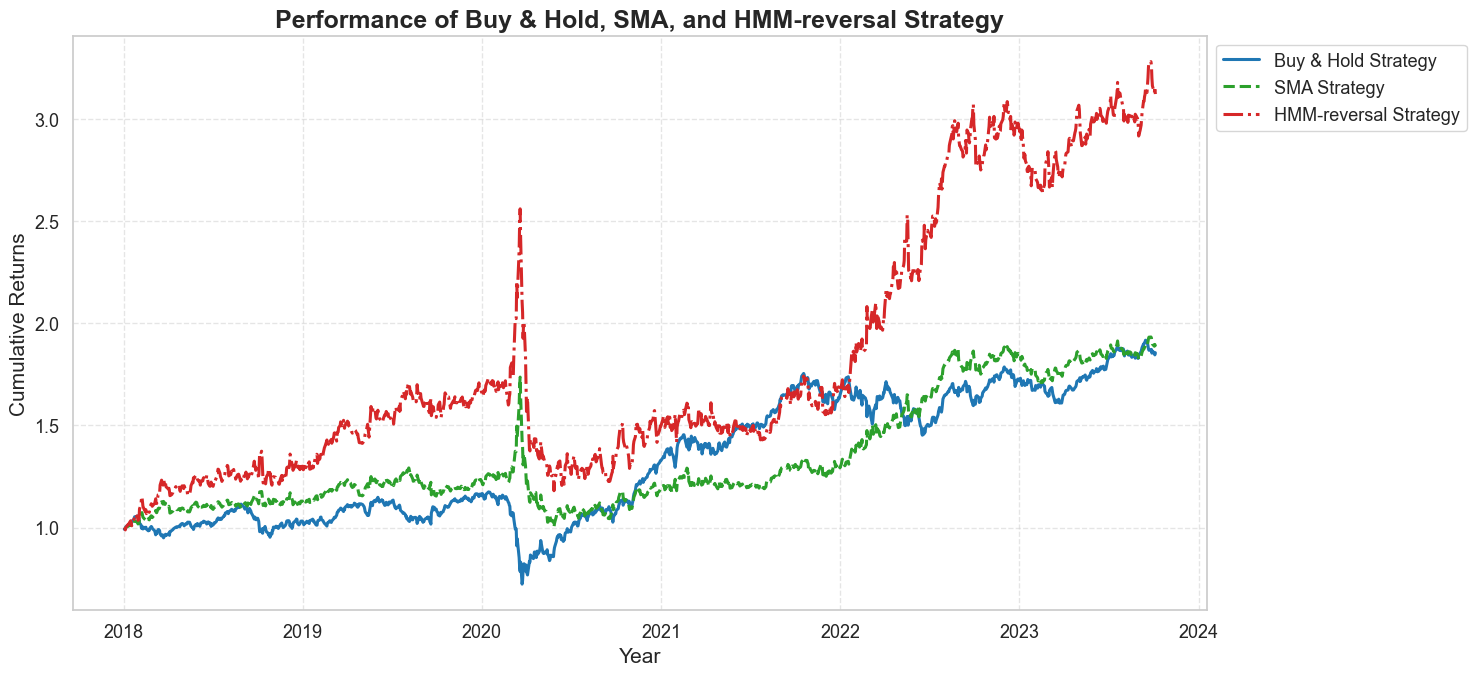

: 

: 

In [ ]:
import seaborn as sns


sns.set_style("whitegrid")

fig, ax = plt.subplots(figsize=(15, 7))

ax.plot(plot_data.index, plot_data['buy_hold_cum_rets'], label="Buy & Hold Strategy", color='#1f77b4', linewidth=2.2)
ax.plot(plot_data.index, plot_data['basic_stra_cum_rets'], label="SMA Strategy", color='#2ca02c', linestyle='--', linewidth=2.2)
ax.plot(plot_data.index, plot_data['hmm_dc_stra_cum_rets'], label="HMM-reversal Strategy", color='#d62728', linestyle='-.', linewidth=2.2)

ax.set_title('Performance of Buy & Hold, SMA, and HMM-reversal Strategy', fontsize=18, fontweight='bold')
ax.set_xlabel('Year', fontsize=15)
ax.set_ylabel('Cumulative Returns', fontsize=15)

ax.tick_params(axis='both', labelsize=13)

ax.grid(alpha=0.5, linestyle='--')
ax.legend(loc='upper left', fontsize=13, frameon=True, bbox_to_anchor=(1, 1))

plt.tight_layout()
plt.show()

Start date,2018-01-03
End date,2023-10-05
Total months,67
,Backtest
Annual return,11.8%
Cumulative returns,87.2%
Annual volatility,18.5%
Sharpe ratio,0.70
Calmar ratio,0.31
Stability,0.81
Max drawdown,-38.4%


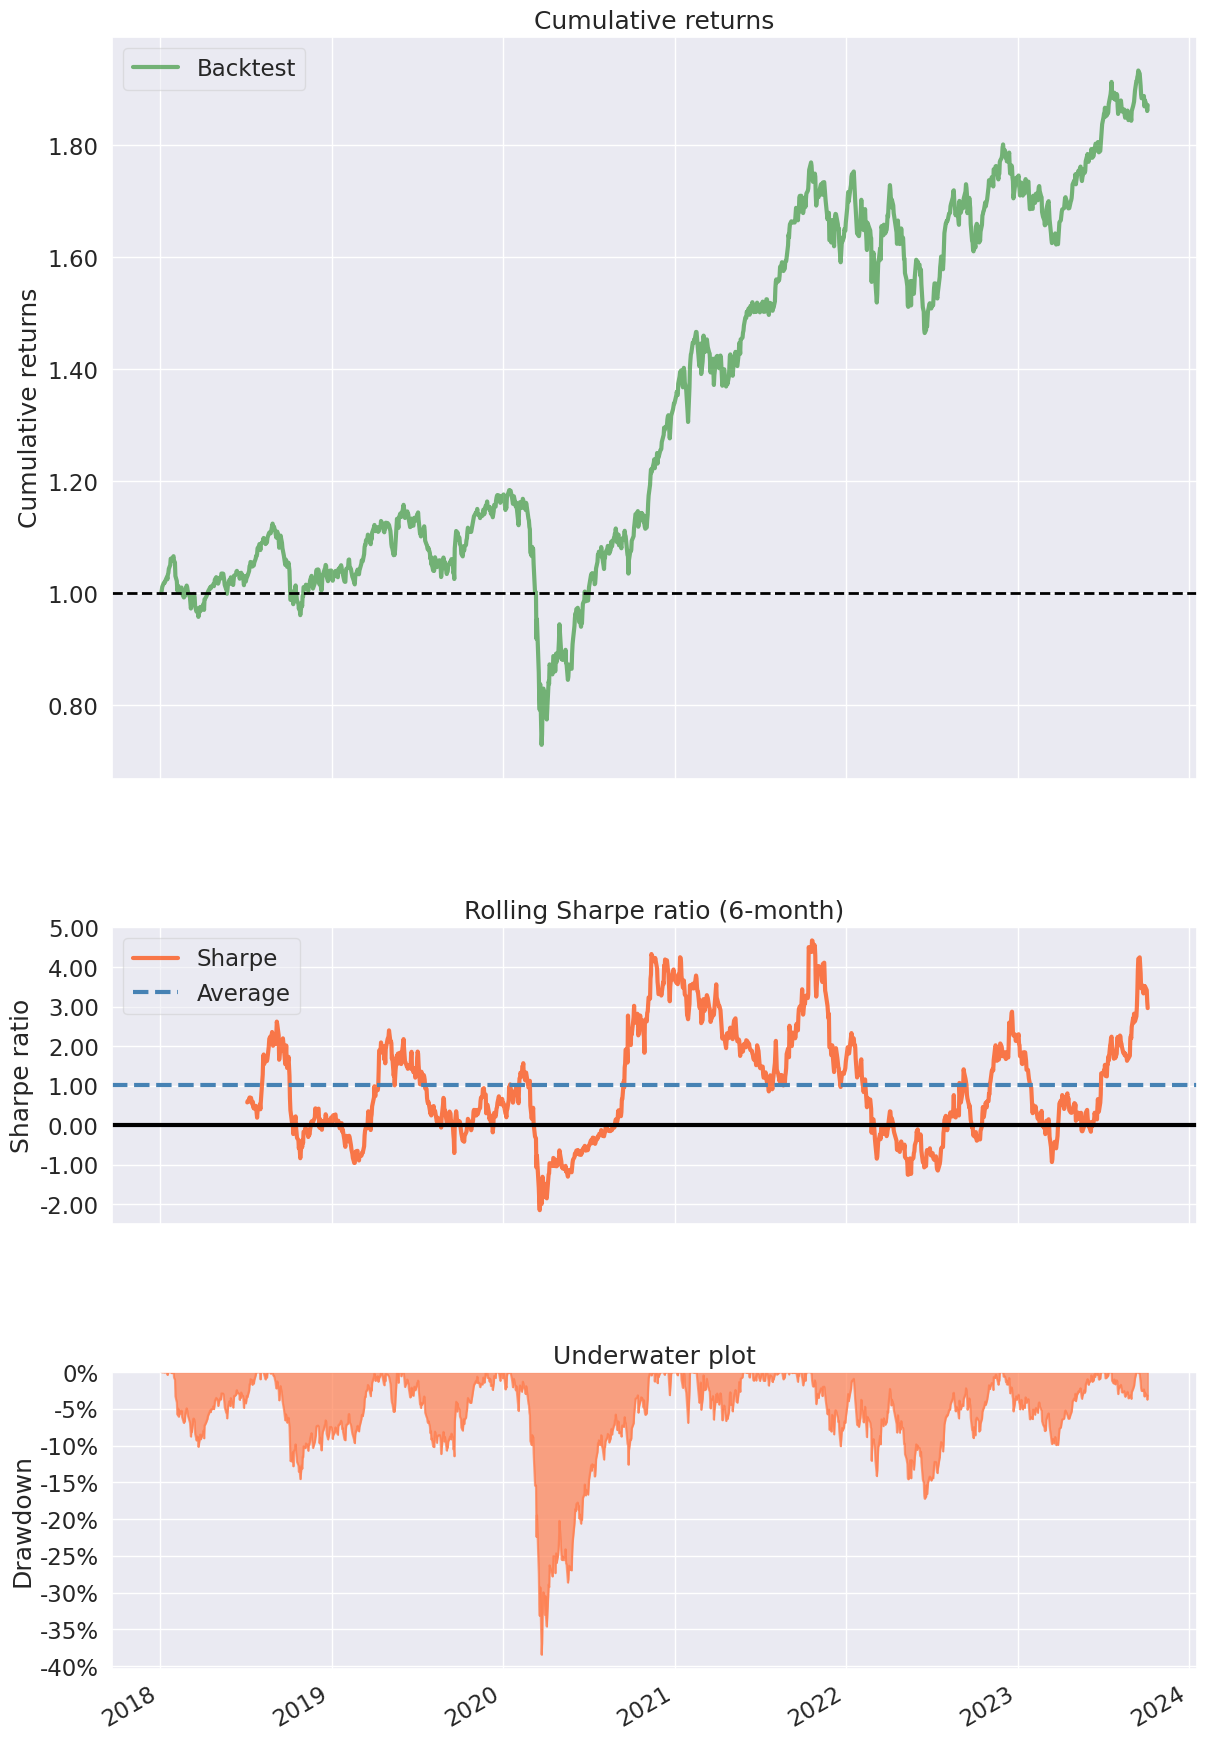

: 

: 

In [ ]:
pf.create_simple_tear_sheet(plot_data['buy_hold_cum_rets'].pct_change().dropna())

Start date,2018-01-04
End date,2023-10-05
Total months,67
,Backtest
Annual return,11.9%
Cumulative returns,88.6%
Annual volatility,18.5%
Sharpe ratio,0.70
Calmar ratio,0.28
Stability,0.74
Max drawdown,-42.4%


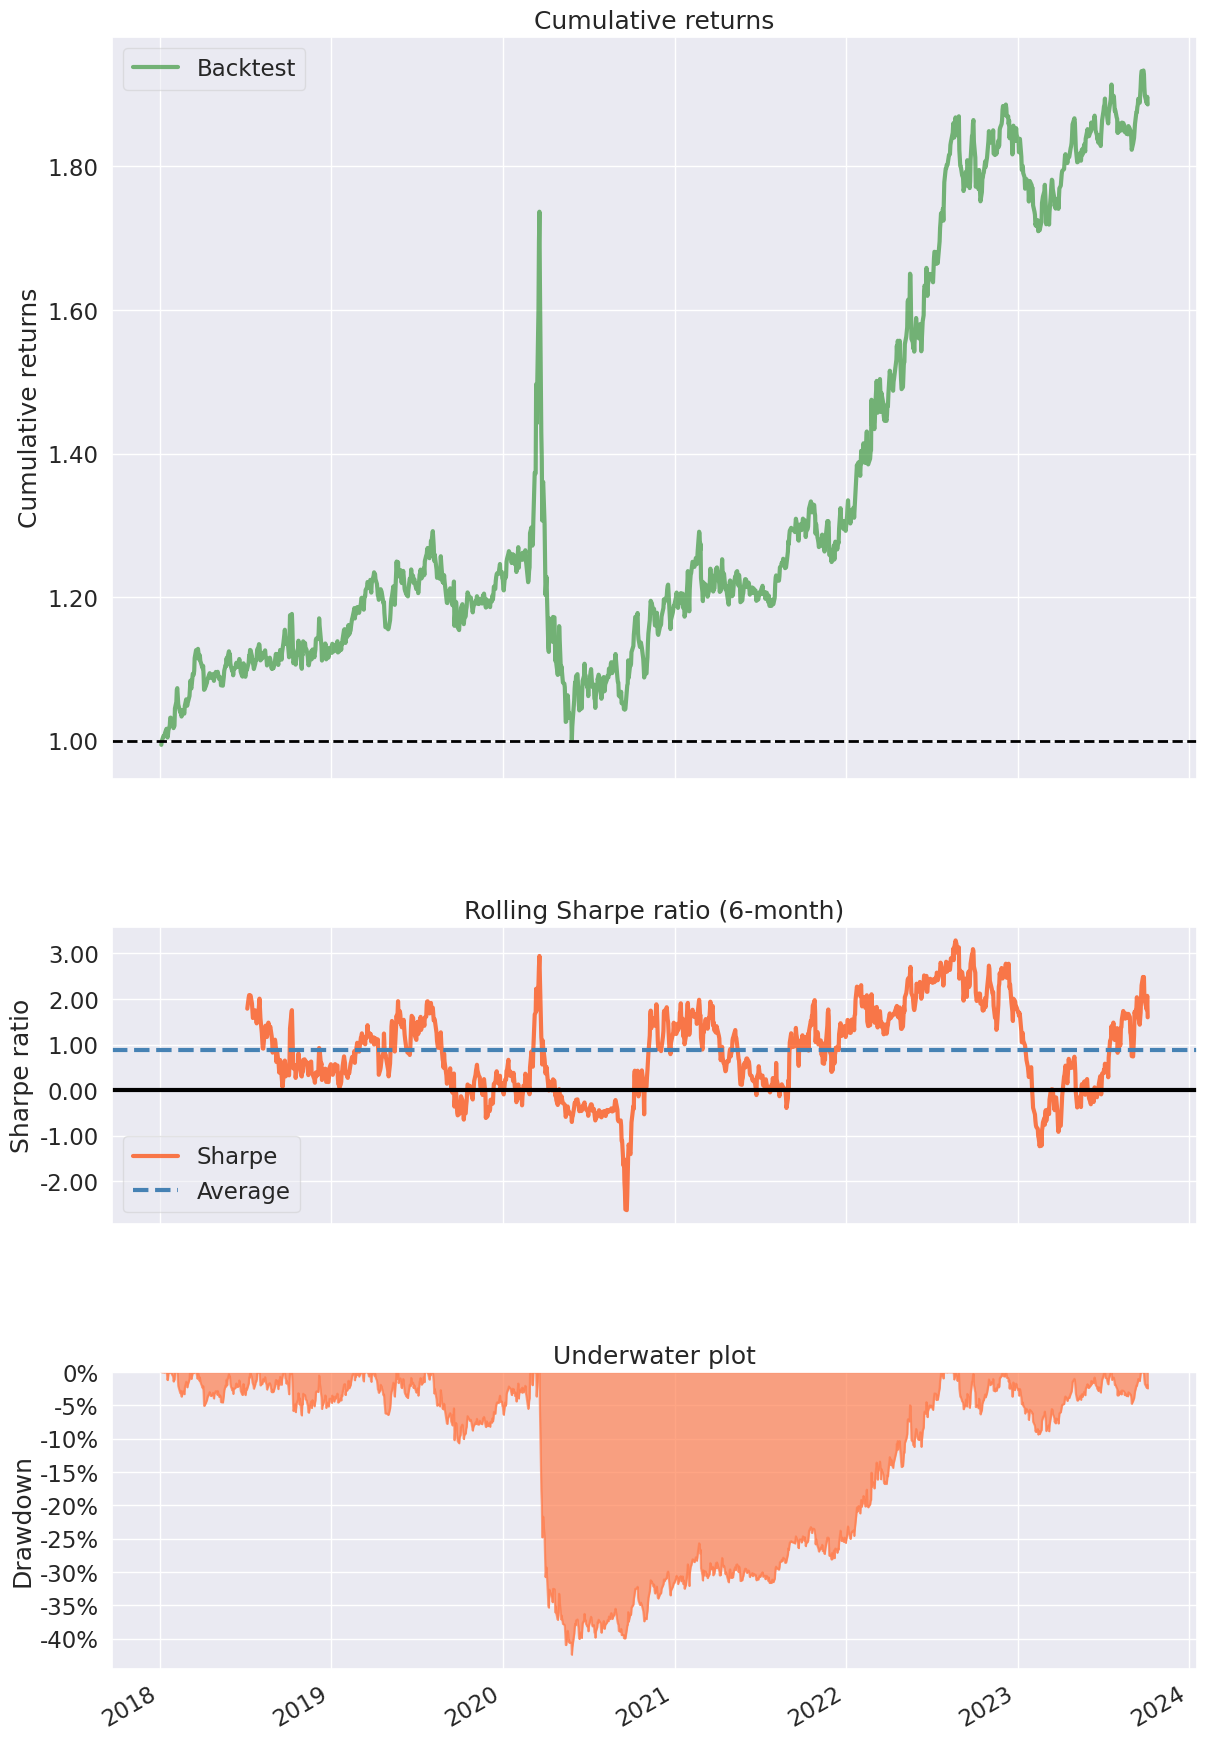

: 

: 

In [ ]:
pf.create_simple_tear_sheet(plot_data['basic_stra_cum_rets'].pct_change().dropna())

Start date,2018-01-04
End date,2023-10-05
Total months,67
,Backtest
Annual return,22.4%
Cumulative returns,212.4%
Annual volatility,28.6%
Sharpe ratio,0.85
Calmar ratio,0.42
Stability,0.76
Max drawdown,-53.9%


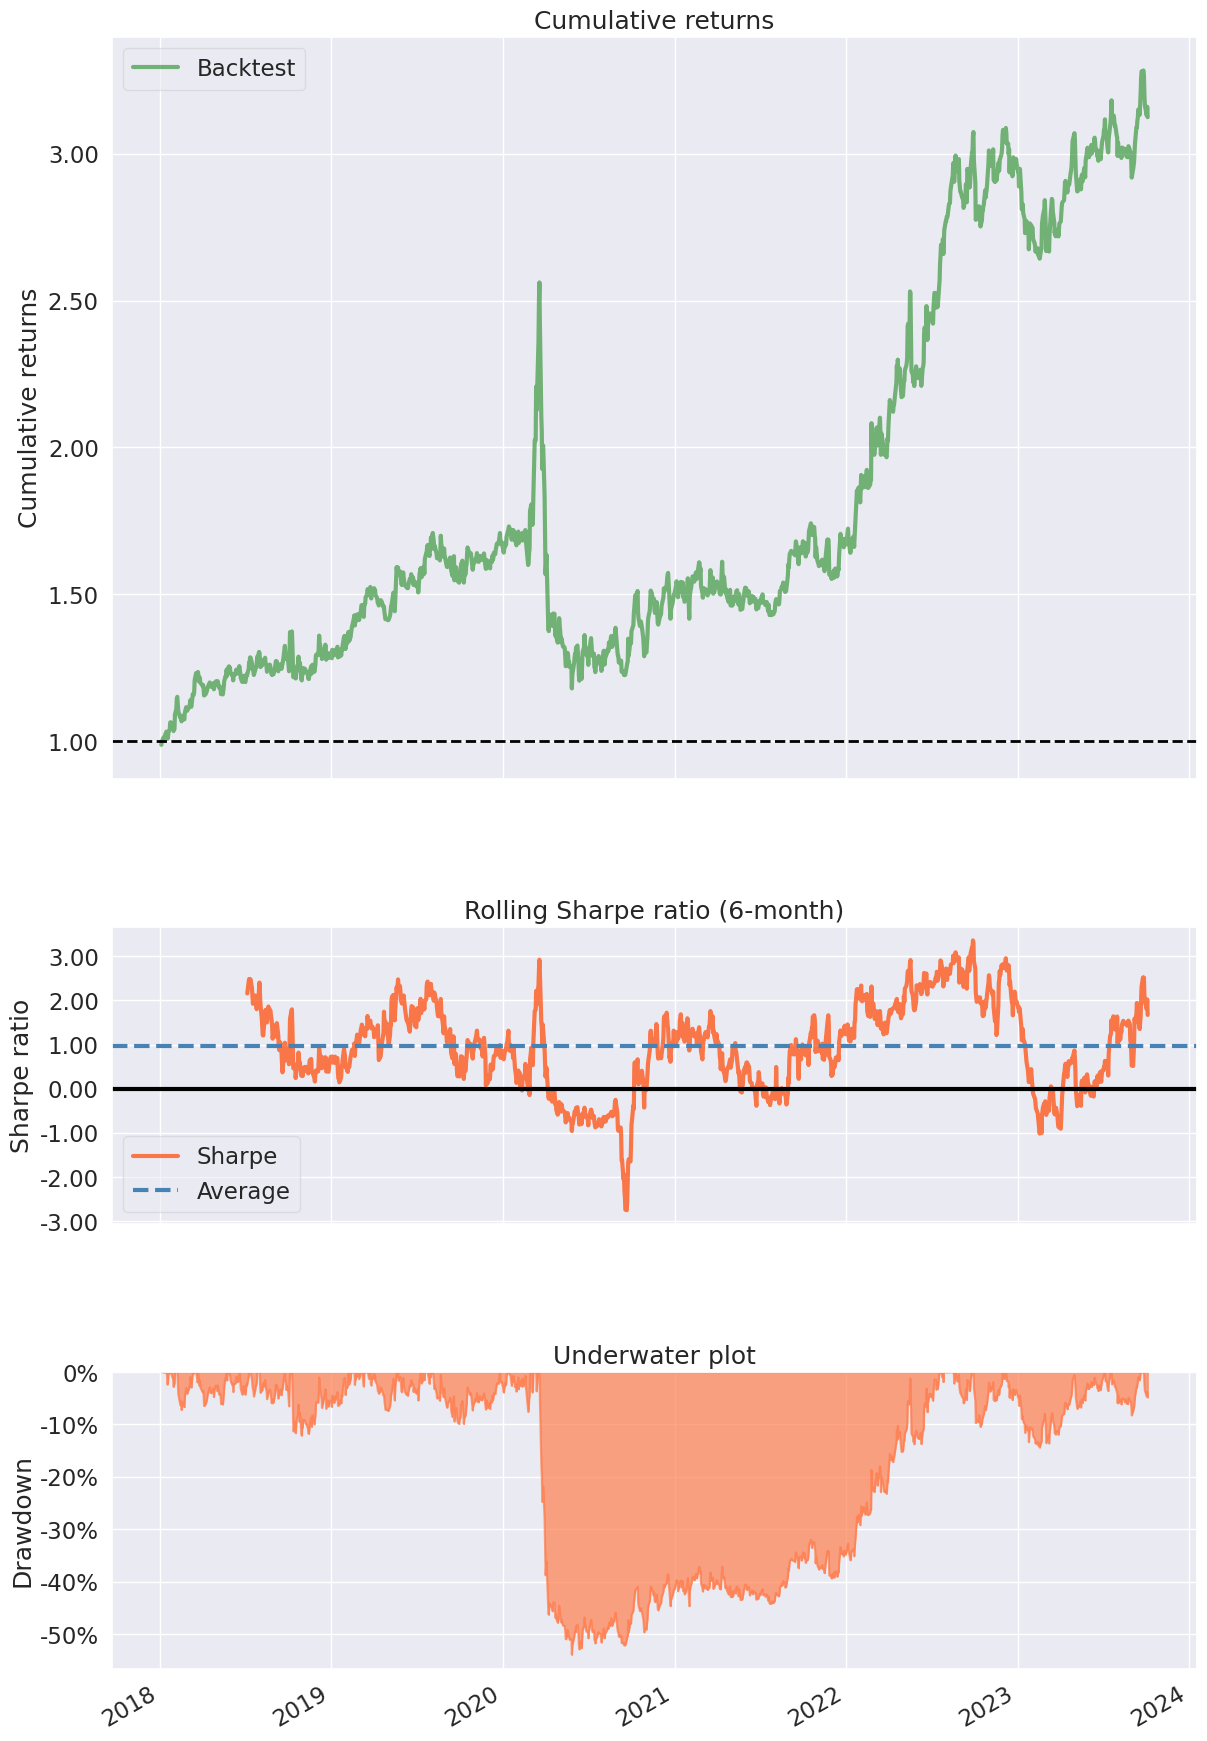

: 

: 

In [ ]:
pf.create_simple_tear_sheet(plot_data['hmm_dc_stra_cum_rets'].pct_change().dropna())